In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D, Dense, Dropout , Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import glob
import cv2
import keras
import tensorflow as tf




import warnings
warnings.filterwarnings('ignore')

# Prepare and load dataset

In [23]:
x_train = []
y_train = []
for img in glob.glob("/content/drive/MyDrive/datasets2/Covid19-dataset/train/Covid/*.jpeg"):
    n = cv2.imread(img)
    n = cv2.resize(n, (130,130), interpolation = cv2.INTER_AREA)
    x_train.append(n)
    y_train.append( 0)

for img in glob.glob("/content/drive/MyDrive/datasets2/Covid19-dataset/train/Normal/*.jpeg"):
    n = cv2.imread(img)
    n = cv2.resize(n, (130,130), interpolation = cv2.INTER_AREA)
    x_train.append(n)
    y_train.append( 1)


for img in glob.glob(r"/content/drive/MyDrive/datasets2/Covid19-dataset/train/Viral Pneumonia/*.jpeg"):
    n = cv2.imread(img)
    n = cv2.resize(n, (130,130), interpolation = cv2.INTER_AREA)
    x_train.append(n)
    y_train.append( 2)




In [24]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

# Prepare and load data Test

In [25]:
x_test = []
y_test = []
for img in glob.glob("/content/drive/MyDrive/datasets2/Covid19-dataset/test/Covid/*.jpeg"):
    n = cv2.imread(img)
    n = cv2.resize(n, (130,130), interpolation = cv2.INTER_AREA)
    x_test.append(n)
    y_test.append(0)

for img in glob.glob("/content/drive/MyDrive/datasets2/Covid19-dataset/test/Normal/*.jpeg"):
    n = cv2.imread(img)
    n = cv2.resize(n, (130,130), interpolation = cv2.INTER_AREA)
    x_test.append(n)
    y_test.append( 1)


for img in glob.glob("/content/drive/MyDrive/datasets2/Covid19-dataset/test/Viral Pneumonia/*.jpeg"):
    n = cv2.imread(img)
    n = cv2.resize(n, (130,130), interpolation = cv2.INTER_AREA)
    x_test.append(n)
    y_test.append( 2)

# Preprocess the data

In [27]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [28]:
from tensorflow.keras.applications.resnet import preprocess_input 

train_ds = preprocess_input(x_train)
valid_ds = preprocess_input(x_valid) 
test_ds = preprocess_input(x_test)

# Create the base model from the pre-trained model ResNet152

In [29]:
from tensorflow.keras.applications.resnet import ResNet152

base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (130,130,3))
for layer in base_model.layers:
  layer.trainable = False

In [30]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(4096,activation='relu'))
model.add(Dense(4096,activation='relu'))
model.add(Dense(3 , activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# Train the model

In [31]:
from tensorflow.keras.callbacks import EarlyStopping



history = model.fit(train_ds,y_train, validation_data= (valid_ds,y_valid),  
                              epochs=50,
                              verbose=1,callbacks=[tf.keras.callbacks.EarlyStopping
                               (monitor="val_loss",
                                patience=30,verbose=1,
                                restore_best_weights=True),
                               ])

Epoch 1/50
5/5 [==============================] - 14s 2s/step - loss: 332.5443 - accuracy: 0.3354 - val_loss: 5.5959 - val_accuracy: 0.8214
Epoch 2/50
5/5 [==============================] - 2s 398ms/step - loss: 3.2740 - accuracy: 0.6962 - val_loss: 0.5489 - val_accuracy: 0.9286
Epoch 3/50
5/5 [==============================] - 1s 184ms/step - loss: 0.7208 - accuracy: 0.9494 - val_loss: 0.5506 - val_accuracy: 0.9286
Epoch 4/50
5/5 [==============================] - 1s 184ms/step - loss: 0.5919 - accuracy: 0.9430 - val_loss: 2.3295 - val_accuracy: 0.8571
Epoch 5/50
5/5 [==============================] - 1s 196ms/step - loss: 0.1373 - accuracy: 0.9747 - val_loss: 0.9307 - val_accuracy: 0.7500
Epoch 6/50
5/5 [==============================] - 1s 186ms/step - loss: 0.1451 - accuracy: 0.9620 - val_loss: 0.7210 - val_accuracy: 0.9286
Epoch 7/50
5/5 [==============================] - 2s 419ms/step - loss: 9.6996e-05 - accuracy: 1.0000 - val_loss: 0.3812 - val_accuracy: 0.9643
Epoch 8/50
5/5 [

# plot the loss and accuracy of the model

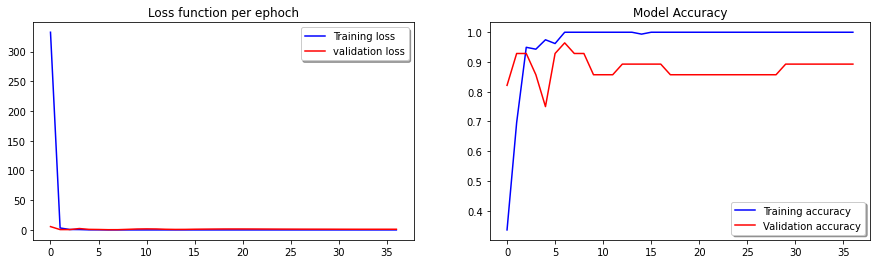

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_title('Loss function per ephoch')
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].set_title('Model Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

# train & test loss and accuracy

In [33]:
train_loss, train_acc= model.evaluate(train_ds,y_train)
print('train acc:', train_acc)
print('train loss:', train_loss)

5/5 [==============================] - 1s 120ms/step - loss: 0.0010 - accuracy: 1.0000
train acc: 1.0
train loss: 0.0010126514825969934


In [34]:
test_loss, test_acc = model.evaluate(test_ds,y_test)
print('test acc:', test_acc)
print('test loss:', test_loss)

2/2 [==============================] - 1s 541ms/step - loss: 0.8089 - accuracy: 0.9038
test acc: 0.9038461446762085
test loss: 0.8089081048965454
